<a href="https://colab.research.google.com/github/jgy4/stable-baselines3/blob/main/HW1_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]

## Installations & Imports

In [2]:
import stable_baselines3
stable_baselines3.__version__

'1.4.0'

In [85]:
import gym
import numpy as np
import matplotlib.pyplot as plt

#Imports
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.evaluation import evaluate_policy

In [57]:
#Create Callback Function

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

## Train & Monitor The Agent 
## CartPole Game

In [63]:
#Train & Monitor Agent 

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('CartPole-v1')
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

# Create action noise because TD3 and DDPG use a deterministic policy
#n_actions = env.action_space.shape[-1]
#action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Create RL model
model = A2C('MlpPolicy', env, verbose=0)
# Train the agent
model.learn(total_timesteps=int(5e4), callback=callback)

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 27.40
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 2000
Best mean reward: 27.40 - Last mean reward per episode: 31.92
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 3000
Best mean reward: 31.92 - Last mean reward per episode: 37.13
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 4000
Best mean reward: 37.13 - Last mean reward per episode: 46.05
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 5000
Best mean reward: 46.05 - Last mean reward per episode: 54.61
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 6000
Best mean reward: 54.61 - Last mean reward per episode: 61.93
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 7000
Best mean reward: 61.93 - Last mean reward per episode: 67.49
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 8000
Best mean reward: 67.49 - Last mean reward per episode: 74.72
Sa

## Visualize Training

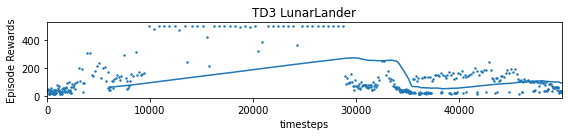

In [82]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "TD3 LunarLander")

In [83]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

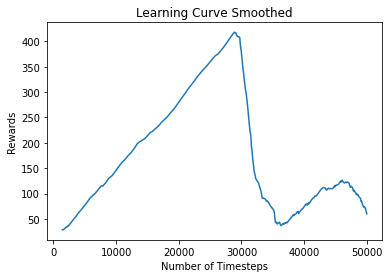

In [86]:
plot_results(log_dir)

## Saving, Loading, and Evaluating The Agent

In [64]:
# Save the agent
model.save("a2c_CartPole")

#Save The Policy
policy = model.policy
policy.save("a2c_policy_CartPole.pkl")
  
# delete trained model to demonstrate loading
del model

In [72]:
#Load Agent
model = A2C.load("a2c_CartPole")

In [74]:
# We create a separate environment for evaluation
eval_env = gym.make('CartPole-v1')

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)

print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

mean_reward=25.60 +/- 3.746998799039039


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


## Final Evaluation Video

In [75]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [77]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [79]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make('CartPole-v1')])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

In [80]:
record_video('CartPole-v1', model, video_length=500, prefix='a2c-CartPole')

Saving video to /content/videos/a2c-CartPole-step-0-to-step-500.mp4


In [81]:
show_videos('videos', prefix='a2c-CartPole')